In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Aqui basicamente fazemos uma reprodução dos exemplos do Brunton (pág. 54)
que usam PCA nas eigenfaces, porém para o nosso conjunto de placas.

Tentei até mesmo manter o conjunto num formato parecido para que o código
ficasse o mais similar possível.

Para ver como o conjunto foi construído, veja o outro notebook.

In [2]:
faces = np.load('placas.npy')

In [3]:
m, n = 65, 200
nfaces = np.array([64] * 38)
nfaces

array([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64])

Acima vemos que temos 64 imagens para cada placa.
As distorções podem ser vistas no outro notebook, onde montamos o conjunto.

Mostrando a primeira imagem de cada placa...

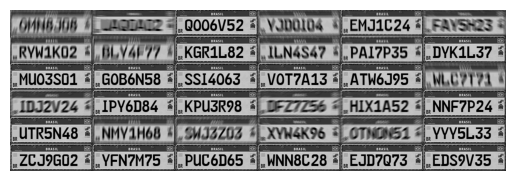

In [4]:
allPersons = np.zeros((n* 6, m * 6))
count = 0

for j in range(6):
    for k in range(6):
        allPersons[j*n : (j+1)*n, k*m : (k+1)*m] = np.reshape(faces[:,np.sum(nfaces[:count])],(m,n)).T
        count += 1

img = plt.imshow(allPersons.T, cmap='gray')
plt.axis('off')
plt.show()

Vamos pegar todas as imagens das 36 primeiras placas para ajustar nosso modelo.

In [5]:
trainingFaces = faces[:,:np.sum(nfaces[:36])]
avgFace = np.mean(trainingFaces,axis=1)

Subtraímos a placa média (das linhas) do conjunto, para fazer o PCA.

In [6]:
X = trainingFaces - np.tile(avgFace,(trainingFaces.shape[1],1)).T

In [7]:
X.shape

(13000, 2304)

Aqui, faremos o PCA via SVD nos datos com média subtraída (*SVD on mean-subtracted data*, pág. 54 do Brunton).

Dado o PCA numa matriz $X$
1. Computamos a média de $X$ a partir de suas linhas
$$\bar{x}_j = \frac{1}{n} \sum_{i=1}^n X_{ij}$$
$$\bar{X} = \begin{bmatrix}
1 \\
\vdots \\
1 
\end{bmatrix}\bar{x}$$

2. Calculamos uma matriz $B$
$$B = X - \bar{X}$$

3. Fazemos a decomposição SVD de $B$
$$B = \tilde{U}\tilde{\Sigma}\tilde{V}^T$$
onde o til representa o truncamento por um $r$ dado, dependendo do número de componentes desejados no PCA.

In [8]:
U, S, VT = np.linalg.svd(X, full_matrices=False)

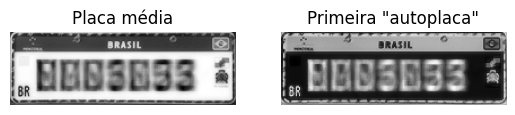

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
img_avg = ax1.imshow(np.reshape(avgFace,(m,n)), cmap='gray')
img_u1 = ax2.imshow(np.reshape(U[:,0],(m,n)), cmap='gray')
ax1.axis('off')
ax2.axis('off')
# titulos
ax1.set_title('Placa média')
ax2.set_title('Primeira "autoplaca"') # autovalor reshaped
plt.show()

Por "autoplaca" queremos dizer os autovetores dos dados, dispostos nas colunas $U$.

Muito interessante! Perceba como todos os dígitos se assemelham a um display alfanumérico desligado.

Testemos agora reconstruções utilizando diferentes ranks $r$.

Lembrando que, dada nossa abordagem para o PCA, para reconstruir, seguimos os passos:
1. Pegamos a placa $y$ que desejamos reconstruir e subtraímos dela a placa média: $\tilde{y} = y - \bar{x}$
1. Calculamos a reconstrução via SVD: $y_{SVD} = \tilde{U}\tilde{U}^T \tilde{y}$
1. Somamos à reconstrução a média, de volta: $y' = \bar{x} + y_{SVD}$

Testes com diferentes $r$ podem ser vistos abaixo, para uma das placas do conjunto de teste.

0
1
2
3
4


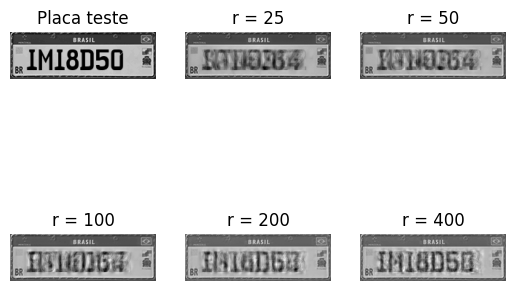

In [10]:
testFace = faces[:,np.sum(nfaces[:36])]
testFaceMS = testFace - avgFace
r_list = [25, 50, 100, 200, 400]
# create 2x4 grid
fig, axs = plt.subplots(2, 3)

# plot test face
axs[0, 0].imshow(np.reshape(testFace,(m,n)), cmap='gray')
axs[0, 0].set_title('Placa teste')
axs[0, 0].axis('off')

for i, ax in enumerate(axs.flat[1:]):
    print(i)
    r = r_list[i]
    reconFace = avgFace + U[:,:r] @ U[:,:r].T @ testFaceMS
    faceshow = np.reshape(reconFace,(m,n))
    ax.imshow(faceshow, cmap='gray')
    ax.set_title('r = ' + str(r))
    ax.axis('off')
plt.show()

Vamos testar com uma imagem externa ao banco.

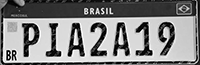

In [11]:
# mais um teste
test_im = Image.open('teste.png')
test_im = test_im.convert('L')
test_im

25
50
100
200
400


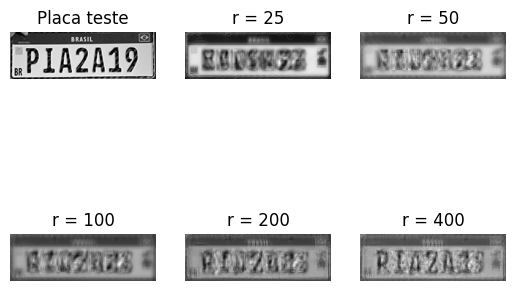

In [12]:
test_im = np.array(test_im).flatten()
test_im_ms = test_im - avgFace

r_list = [25, 50, 100, 200, 400]
# create 2x4 grid
fig, axs = plt.subplots(2, 3)

# plot test face
axs[0, 0].imshow(np.reshape(test_im,(m,n)), cmap='gray')
axs[0, 0].set_title('Placa teste')
axs[0, 0].axis('off')

for i, ax in enumerate(axs.flat[1:]):
    r = r_list[i]
    print(r)
    reconFace = avgFace + U[:,:r] @ U[:,:r].T @ test_im_ms
    faceshow = np.reshape(reconFace,(m,n))
    ax.imshow(faceshow, cmap='gray')
    ax.set_title('r = ' + str(r))
    ax.axis('off')
plt.show()

Vamos testar com uma imagem externa _e com ruído_.

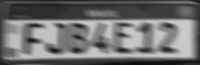

In [13]:
# mais um teste
test_im2 = Image.open('teste-blur.png')
test_im2 = test_im2.convert('L')
# test_img rescale to 200, 65
test_im2 = test_im2.resize((200, 65))
test_im2

25
50
100
200
400


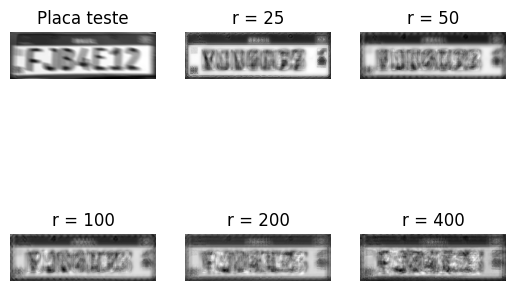

In [14]:
test_im2 = np.array(test_im2).flatten()
test_im2_ms = test_im2 - avgFace

r_list = [25, 50, 100, 200, 400]
# create 2x4 grid
fig, axs = plt.subplots(2, 3)

# plot test face
axs[0, 0].imshow(np.reshape(test_im2,(m,n)), cmap='gray')
axs[0, 0].set_title('Placa teste')
axs[0, 0].axis('off')

for i, ax in enumerate(axs.flat[1:]):
    r = r_list[i]
    print(r)
    reconFace = avgFace + U[:,:r] @ U[:,:r].T @ test_im2_ms
    faceshow = np.reshape(reconFace,(m,n))
    ax.imshow(faceshow, cmap='gray')
    ax.set_title('r = ' + str(r))
    ax.axis('off')
plt.show()